# CONDITIONAL WGAN-GP ON CelebA FACES

In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import (
    utils,
    layers,
    models,
    metrics,
    optimizers,
    callbacks
)
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

## SETTINGS

In [12]:
celeba_path='./datasets/celebA/'

## FUNCTIONS

In [13]:
def preprocess(img):
    img=(tf.cast(img,'float32')-127.5)/127.5
    return img

def sample_batch(dataset):
    batch=dataset.take(1).get_single_element()

    if isinstance(batch,tuple):
        batch=batch[0]
    return batch.numpy()

def display_img(images, n=10, fig_size=(20, 3), c_map='gray_r', as_type='float32', save_to=None):
    if save_to is not None:
        oFull_path = Path(save_to)
        # Создаем все промежуточные каталоги, если они не существуют
        oFull_path.parent.mkdir(parents=True, exist_ok=True)

    # Нормализация изображений
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=fig_size)

    for i in range(n):
        plt.imshow(images[i].astype(as_type), cmap=c_map)
        plt.axis('off')

    # Сохранение изображения
    if save_to:
        plt.savefig(save_to)

    plt.show()
    

## PREPARE LABELS

In [14]:
celeba_attributes_df=pd.read_csv(celeba_path + 'list_attr_celeba.csv')

In [15]:
celeba_attributes_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [16]:
celeba_attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [17]:
filtered_labels=celeba_attributes_df['Blond_Hair'].tolist()
int_labels=[x if x==1 else 0 for x in filtered_labels]

**ATTENTION**

Code in a cell below well fit to the book project, because the labels dataset sorted and relevant to the celebA folder structure. But if you going to repeat this trick with different dataset you may end-up with the situation when your lables doesn't fit to the files so befoure process different datasets make sure to carefully ecxplore folder and labels to make sure its order match each-other

Here is how you can check order of the target folder walk
```python
directory = './celebA/img_align_celeba'

file_paths = []
file_count = 0
max_files = 5

for root, dirs, files in os.walk(directory):
    for file in files:
        if file_count >= max_files:  
            break
        full_path = os.path.join(root, file)
        file_paths.append(full_path)
        file_count += 1

    if file_count >= max_files: 
        break

print("First 5:", file_paths)
First 5: ['./celebA/img_align_celeba/000001.jpg', './celebA/img_align_celeba/000002.jpg', './celebA/img_align_celeba/000003.jpg', './celebA/img_align_celeba/000004.jpg', './celebA/img_align_celeba/000005.jpg']
```

In [18]:
%%time
# ~7 min

CLASSES=2
if 'train_data' not in globals():
    train_data=utils.image_dataset_from_directory(
        directory='./datasets//celebA/img_align_celeba',
        labels=int_labels,
        color_mode='rgb',
        image_size=(64,64),
        batch_size=128,
        shuffle=True, # Note that this param will cause shuffeling not once but everytime you iterate over dataset
        seed=42,
        interpolation='bilinear'
    )
    train=train_data.map(
        lambda x,y: (preprocess(x), tf.one_hot(y,depth=CLASSES))
    )
else:
    print(f'train_data has been already initialized, no action needed')

Found 202599 files belonging to 2 classes.


2024-11-07 22:49:03.084581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 22:49:03.137656: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 22:49:03.137708: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 22:49:03.140608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 22:49:03.140662: I external/local_xla/xla/stream_executor

Cause: could not parse the source code of <function <lambda> at 0x7f2f8a21c400>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f2f8a21c400>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 14.9 s, sys: 20.7 s, total: 35.6 s
Wall time: 2min 33s


In [19]:
# Check number of batches
train.cardinality().numpy()

1583

In [20]:
# Inspect image shape and label
for img, label in train_data.take(1):
    print("Image shape:", img.shape)
    print("Label:", label)

Image shape: (128, 64, 64, 3)
Label: tf.Tensor(
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0], shape=(128,), dtype=int32)


2024-11-07 22:49:05.222469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Description**

What we can see here is that our dataset 'train_dataset' formed as a set of batches where each batch return 128 color(3-rgb) images shape of 64x64 with labels as tensor with dedicated values of 0 and 1 not onehot encoded

The Warning below mean
```
2024-10-29 14:40:48.699020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
```
That dataset take(1) iteration has been compleeted. As we see that all data has been processed this message could be ignored

Filtered Images Shape: (17, 64, 64, 3)
Filtered Labels: tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(17,), dtype=int32)


2024-11-07 22:49:05.523446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


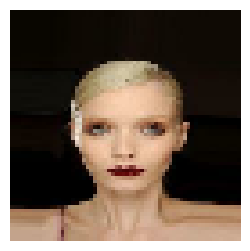

In [21]:
# Take one batch
for img_batch, label_batch in train_data.take(1):
    # Create filter mask where labels=1
    mask = tf.equal(label_batch, 1)
    
    # Apply mask for filtering images and labels
    filtered_images = tf.boolean_mask(img_batch, mask)
    filtered_labels = tf.boolean_mask(label_batch, mask)
    images_np = filtered_images.numpy()
   
    print("Filtered Images Shape:", filtered_images.shape)
    print("Filtered Labels:", filtered_labels)

display_img(images_np,c_map=None)

**Description**

We have successfully filtered images with label=1 which is confirmed by image output above

## BUILDING THE GAN

### CRITIC

In [22]:
IMAGE_W=64
IMAGE_H=64
IMAGE_C=3
critic_input=layers.Input(
    shape=(IMAGE_W,IMAGE_H,IMAGE_C)    
)

label_input=layers.Input(
    shape=(IMAGE_W,IMAGE_W,CLASSES)
)

x=layers.Concatenate(axis=-1)([critic_input,label_input])
x=layers.Conv2D(
    64,
    kernel_size=4,
    strides=2,
    padding='same'
)(x)
x=layers.LeakyReLU(.2)(x)

x=layers.Conv2D(
    128,
    kernel_size=4,
    strides=2,
    padding='same'
)(x)
x=layers.LeakyReLU()(x)
x=layers.Dropout(.3)(x)

x=layers.Conv2D(
    128,
    kernel_size=4,
    strides=2,
    padding='same'
)(x)
x=layers.LeakyReLU(.2)(x)
x=layers.Dropout(.3)(x)

x=layers.Conv2D(
    128,
    kernel_size=4,
    strides=2,
    padding='same'
)(x)
x=layers.LeakyReLU(.2)(x)
x=layers.Dropout(.3)(x)

x=layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding='valid'
)(x)

critic_output=layers.Flatten()(x)
critic=models.Model([critic_input,label_input],critic_output)

In [23]:
critic.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 64, 64, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64, 5) │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      5,184 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │    262,272 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 128) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 128) │    262,272 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 4, 4, 128) │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 128) │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 1)   │      2,049 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ conv2d_4[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

### GENERATOR

In [24]:
Z_DIM=32
generator_input=layers.Input(shape=(Z_DIM,))
label_input=layers.Input(shape=(CLASSES,))

x=layers.Concatenate(axis=-1)([generator_input,label_input])
x=layers.Reshape((1,1,Z_DIM + CLASSES))(x)

x=layers.Conv2DTranspose(
    128,
    kernel_size=4,
    strides=1,
    padding='valid',
    use_bias=False
)(x)
x=layers.BatchNormalization( momentum=.9)(x)
x=layers.LeakyReLU(.2)(x)

x=layers.Conv2DTranspose(
    128,
    kernel_size=4,
    strides=2,
    padding='same',
    use_bias=False
)(x)
x=layers.BatchNormalization(momentum=.9)(x)
x=layers.LeakyReLU(.2)(x)

x=layers.Conv2DTranspose(
    128,
    kernel_size=4,
    strides=2,
    padding='same',
    use_bias=False
)(x)
x=layers.BatchNormalization(momentum=.9)(x)
x=layers.LeakyReLU(.2)(x)

x=layers.Conv2DTranspose(
    64,
    kernel_size=4,
    strides=2,
    padding='same',
    use_bias=False
)(x)
x=layers.BatchNormalization(momentum=.9)(x)
x=layers.LeakyReLU(.2)(x)

generator_output=layers.Conv2DTranspose(
    IMAGE_C,
    kernel_size=4,
    strides=2,
    padding='same',
    activation='tanh'
)(x)

generator=models.Model([generator_input,label_input],generator_output)

In [25]:
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 34)        │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 34)  │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 4, 4, 128) │     69,632 │ reshape[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4, 4, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 8, 8, 128) │    262,144 │ leaky_re_lu_4[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 16, 16,    │    262,144 │ leaky_re_lu_5[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 32, 32,    │    131,072 │ leaky_re_lu_6[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64, 3) │      3,075 │ leaky_re_lu_7[0]… │
│ (Conv2DTranspose)   │                   │            │                 

 Total params: 729,859 (2.78 MB)

 Trainable params: 728,963 (2.78 MB)

 Non-trainable params: 896 (3.50 KB)

### CONDITIONAL WGAN GP

In [26]:
class ConditionalWGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(ConditionalWGANGP, self).__init__()
        self.critic=critic
        self.generator=generator
        self.latent_dim=latent_dim
        self.critic_steps=critic_steps
        self.gp_weight=gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(ConditionalWGANGP,self).compile(run_eagerly=True)
        self.c_optimizer=c_optimizer
        self.g_optimizer=g_optimizer
        self.c_wass_loss_metric=metrics.Mean(name='c_wass_loss')
        self.c_gp_metric=metrics.Mean(name='c_gp')
        self.c_loss_metric=metrics.Mean(name='c_loss')
        self.g_loss_metric=metrics.Mean(name='g_loss')

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric
        ]

    def gradient_penalty(self,batch_size,real_images,fake_images,image_one_hot_labels):
        alpha=tf.random.normal([batch_size,1,1,1],.0,1.0)
        diff=fake_images-real_images
        interpolated=real_images+alpha*diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred=self.critic([interpolated,image_one_hot_labels], training=True)

        grads=gp_tape.gradient(pred,[interpolated])[0]
        norm=tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3]))
        gp=tf.reduce_mean((norm-1.0)**2)

        return gp

    def train_step(self,data):
        real_images,one_hot_labels=data

        image_one_hot_labels=one_hot_labels[:,None,None,:]
        image_one_hot_labels=tf.repeat(image_one_hot_labels,repeats=64,axis=1)
        image_one_hot_labels=tf.repeat(image_one_hot_labels,repeats=64,axis=2)
        batch_size=tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vector=tf.random.normal(shape=(batch_size,self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images=self.generator([random_latent_vector,one_hot_labels], training=True)
                fake_predictions=self.critic([fake_images,image_one_hot_labels],training=True)
                real_predictions=self.critic([real_images,image_one_hot_labels],training=True)        
                c_wass_loss=tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp=self.gradient_penalty(batch_size,real_images,fake_images,image_one_hot_labels)
                c_loss=c_wass_loss + c_gp * self.gp_weight

            c_gradient=tape.gradient(c_loss,self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient,self.critic.trainable_variables))

        random_latent_vector=tf.random.normal(shape=(batch_size,self.latent_dim))

        with tf.GradientTape() as tape:
            fake_images=self.generator([random_latent_vector,one_hot_labels],training=True)
            fake_predictions=self.critic([fake_images,image_one_hot_labels],training=True)
            g_loss=-tf.reduce_mean(fake_predictions)

        gen_gradient=tape.gradient(g_loss,self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient,self.generator.trainable_variables))
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {
            m.name: m.result() for m in self.metrics
        }    

In [27]:
cgangp=ConditionalWGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=3,
    gp_weight=10.0
)

## TRAIN

### Compile

In [28]:
cgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=5e-5,
        beta_1=.5,
        beta_2=.9
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=5e-5,
        beta_1=.5,
        beta_2=.9
    )
)

### Callbacks

In [29]:
log_dir='./logs/fit/wgangp/celeba/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

model_checkpoint_callback=callbacks.ModelCheckpoint(
    filepath='./checkpoint.weights.h5',
    save_weights_only=True,
    save_freq='epoch',
    verbose=0
)

tensorboard_callback=callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1
)

2024-11-07 22:49:06.838783: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-07 22:49:06.838820: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-07 22:49:06.838863: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1239] Profiler found 1 GPUs
2024-11-07 22:49:06.839290: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:137] cuptiGetTimestamp: error 999: 
2024-11-07 22:49:06.839319: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-11-07 22:49:06.839325: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-11-07 22:49:06.839328: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1281] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with

### ImageGenerator

In [30]:
class ImageGenerator(callbacks.Callback):
    def __init__(self,num_img,latent_dim,save_to):
        self.num_img=num_img
        self.latent_dim=latent_dim
        self.save_to=save_to

    def on_epoch_end(self,epoch,logs=None):
       
        random_latent_vector=tf.random.normal(shape=(self.num_img,self.latent_dim))
        
        zero_label=np.repeat([[1,0]],self.num_img,axis=0)
        zero_label = tf.convert_to_tensor(zero_label, dtype=tf.float32)
        
        generated_images=self.model.generator([random_latent_vector,zero_label])
        generated_images=generated_images * 127.5 + 127.5
        generated_images=generated_images.numpy()

        export_path=self.save_to + '/generated_zero_img%03d.png' % (epoch)
        display_img(
            generated_images,
            c_map=None,
            save_to=export_path
        )

        one_label=np.repeat([[0,1]],self.num_img,axis=0)
        one_label = tf.convert_to_tensor(one_label, dtype=tf.float32)
        
        generated_images=self.model.generator([random_latent_vector,one_label])
        generated_images=generated_images * 127.5 + 127.5
        generated_images=generated_images.numpy()

        export_path=self.save_to + '/generated_one_img%03d.png' % (epoch)
        display_img(
            generated_images,
            c_map=None,
            save_to=export_path
        )                

### Fit

In [31]:
%%time

history=cgangp.fit(
    train,
    epochs=5,
   # steps_per_epoch=1,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10,latent_dim=Z_DIM, save_to=log_dir + '/images')
    ]
)

Epoch 1/5


2024-11-07 22:49:08.075716: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   1/1583 ━━━━━━━━━━━━━━━━━━━━ 2:08:17 5s/step - c_gp: 0.7558 - c_loss: 7.5081 - c_wass_loss: -0.0504 - g_loss: 0.0694

2024-11-07 22:49:11.753770: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-07 22:49:11.753823: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-07 22:49:11.753841: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-11-07 22:49:11.753863: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-11-07 22:49:11.753866: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-11-07 22:49:11.753869: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1281] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 


   2/1583 ━━━━━━━━━━━━━━━━━━━━ 30:02 1s/step - c_gp: 0.7539 - c_loss: 7.4760 - c_wass_loss: -0.0629 - g_loss: 0.0687  

2024-11-07 22:49:12.801359: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-11-07 22:49:12.801993: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2024-11-07 22:49:12.802025: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-11-07 22:49:12.802030: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2024-11-07 22:49:12.835883: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-11-07 22:49:12.835944: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-11-07 22:49:12.835982: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:540]  GpuT

  23/1583 ━━━━━━━━━━━━━━━━━━━━ 28:36 1s/step - c_gp: 0.6293 - c_loss: 3.6427 - c_wass_loss: -2.6498 - g_loss: 0.7916

KeyboardInterrupt: 

**DESCRIPTION**

We can say that with each epoch of inference the output results getting better. In particulary we observe:

- **c_gp(Gradient penalty for the discriminator)**: This penalty is added to the discriminator's loss to enforce stable traning by enssuring the discriminator's gradient norms are close to 1.  
The inference dynamic for this metric is lowering per each epoch which mean the stabilization of the gradient norms.
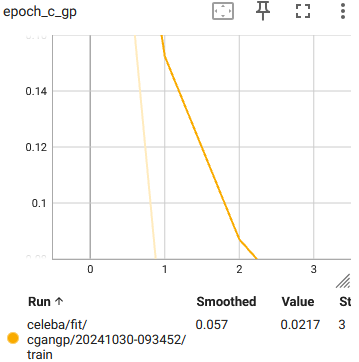
- **c_loss(Discriminator loss)**: Measures the difference between real and generated distributions, reflecting the Wasserstein distance. This metric should be negative in the begining of inference and tend to 0 during the traning, which meaning that in the begining critic can easy distinguish the fake images from real, but during traning process generater getting better and critic losses ability to distingish fakes from real.  
As we can see this metric getting lower, which means that generator improves it's ability to produce good quality images
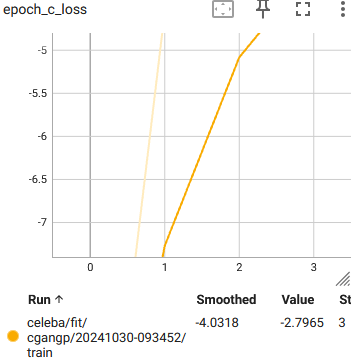
- **c_wass_loss(Wasserstein Loss for the discriminator)**: Reflecting the distance between real and generated images. The higher value meaning the critic improves it ability to differentate between real and fakes.  
Here we also observing lowering trend, which means that critic become less confident in difirentiatig fake from real
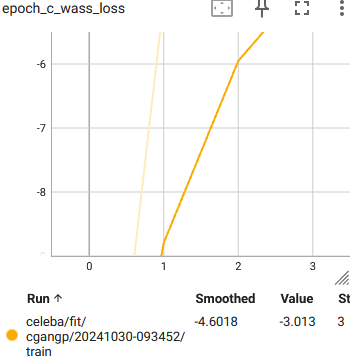
- **g_loss(Generator loss)**: Measures how well generator fools the discriminator. Generators aim is to minimize this metric. An increasing rend suggest the generator producs lower-quality data that the critic can easily identify as fake.  
Lowering trend suggest that generator is improving it ability to generate more realistic images
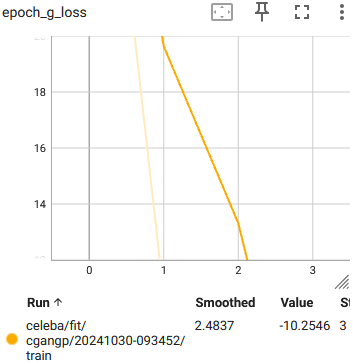



## GENERATE IMAGES

For to control the CGAN output we need to pass in a particular one-hot encoded label into the input of the generator. For the purposes of this project in order to to generate a face with nonblond hair, we pass in the vector [1, 0] and for generate a face with blond hair, we should pass in the vector [0, 1].

In [32]:
z_sample=np.random.normal(size=(10,Z_DIM))

### 0-LABEL (NON BLOND)

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_16', 'keras_tensor_17']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2024-11-07 22:49:37.890514: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


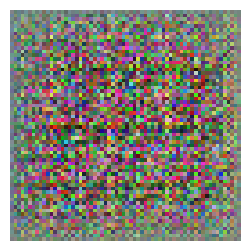

In [33]:
class_label=np.repeat([[1,0]],10,axis=0)
imgs=cgangp.generator.predict([z_sample,class_label])
display_img(imgs,c_map=None, save_to=None)

### 1-LABEL(BLOND HAIR)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


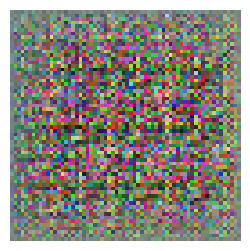

In [34]:
class_label=np.repeat([[0,1]],10,axis=0)
imgs=cgangp.generator.predict([z_sample,class_label])
display_img(imgs,c_map=None,save_to=None)

**DESCRIPTION**

Despite the fact of poor quality of the generated images, we still can clearly see that model were successfully learned blond hair feature and abble to successfully apply this transformation on generated images

**NOTE**  
The reason for overall poor quality of the generated images explained by the small amount of training epochs. Normaly model inference should take at leat 200 epochs.

**References**

1. [Generative Deep Learning, 2nd Edition](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/): David Foster's book from which has become an inspiration of this notebook.
2. [David Foster](https://github.com/davidADSP): GitHub page
3. [David Foster (Keynote) - Generative Deep Learning -Key To Unlocking Artificial General Intelligence?](https://www.youtube.com/watch?v=rHLf78CmNmQ): David's video session at Youtube regarding some key concepts has written in his book
4. [Animated AI](https://www.youtube.com/@animatedai): Youtube channel with amazing visualizations of how exactly 